# Proyecto Redes Neuronales: Transformer Encoder (PyTorch)

**Curso:** Redes Neuronales 2025-II  
**Objetivo:** Entrenar y evaluar un modelo Transformer Encoder usando PyTorch  
**Autor:** Herney Eduardo Quintero Trochez  
**Fecha:** 2025  
**Universidad:** Universidad Del Valle  

## Descripcion del Modelo

El **Transformer** es una arquitectura basada enteramente en mecanismos de atencion (self-attention), sin usar recurrencia ni convolucion. Ventajas sobre RNN/LSTM/GRU:
- Paralelizacion completa del entrenamiento
- Captura dependencias de largo alcance sin degradacion
- Multi-Head Attention permite atender a diferentes aspectos simultaneamente

Este notebook implementa solo el **Encoder** del Transformer para clasificacion de texto.

## 0. Configuracion de Parametros Globales

In [1]:
# Configuracion del experimento
from datetime import datetime as dt
EXPERIMENT_TIMESTAMP = dt.now().strftime("%Y%m%d_%H%M%S")

EXPERIMENT_NAME = "Transformer_PyTorch"
MODEL_TYPE = "Transformer_Torch"
MODEL_SAVE_NAME = f"{MODEL_TYPE}_{EXPERIMENT_TIMESTAMP}"
RANDOM_SEED = 42
PROJECT_PART = "project_part_4"

# Directorios
DATA_DIR = "data"
MODEL_DIR = f"models/{PROJECT_PART}"
OUTPUT_DIR = f"output/{PROJECT_PART}"

# Dataset
TEXT_COLUMN = "review_body"
TITLE_COLUMN = "review_title"
TARGET_COLUMN = "stars"
LANGUAGE_COLUMN = "language"
FILTER_LANGUAGE = "en"
USE_TITLE_AND_BODY = True

# Tokenizacion
MAX_VOCAB_SIZE = 50000
MAX_LENGTH = 200

# Arquitectura del Transformer (optimizada para RTX 5070 12GB)
EMBEDDING_DIM = 512  # Mayor capacidad representacional
NUM_HEADS = 8  # Mantener 8 heads (512/8 = 64 dim por head)
NUM_LAYERS = 6  # Mas capas para mejor aprendizaje
DIM_FEEDFORWARD = 2048  # 4x embedding_dim (estandar en Transformers)
DROPOUT_RATE = 0.1
POOLING = 'mean'  # mean suele funcionar mejor que cls para clasificacion

# Entrenamiento
EPOCHS = 50
BATCH_SIZE = 16  # Reducir para modelo mas grande
LEARNING_RATE = 5e-5  # LR mas bajo para convergencia estable
PATIENCE = 7  # Mas paciencia para modelos grandes
WEIGHT_DECAY = 0.01  # Mas regularizacion
CLIP_GRAD_NORM = 1.0
USE_CLASS_WEIGHTS = True
WARMUP_STEPS = 2000  # Warmup mas largo para estabilidad

print(f"=== Configuracion: {EXPERIMENT_NAME} ===")
print(f"Nombre del modelo: {MODEL_SAVE_NAME}")
print(f"Arquitectura: D={EMBEDDING_DIM}, Heads={NUM_HEADS}, Layers={NUM_LAYERS}, FF={DIM_FEEDFORWARD}")
print(f"Entrenamiento: LR={LEARNING_RATE}, Batch={BATCH_SIZE}, Patience={PATIENCE}")
print(f"GPU: RTX 5070 12GB - Configuracion optimizada")
print("="*60)


=== Configuracion: Transformer_PyTorch ===
Nombre del modelo: Transformer_Torch_20251130_010009
Arquitectura: D=512, Heads=8, Layers=6, FF=2048
Entrenamiento: LR=5e-05, Batch=16, Patience=7
GPU: RTX 5070 12GB - Configuracion optimizada


## 1. Importacion de Librerias

In [2]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from datetime import datetime
from sklearn.metrics import classification_report

# Importar helpers
from helpers.data_loader_torch import DataLoaderTorch
from helpers.model_trainer_torch import ModelTrainerTorch
from helpers.results_manager import ResultsManager
from helpers.visualizer import Visualizer
from helpers.models import TransformerClassifier
from helpers.utils import (
    setup_experiment_environment_torch,
    save_model_components_torch,
    evaluate_model_torch
)

# Configurar ambiente
gpu_info = setup_experiment_environment_torch(RANDOM_SEED)

GPU configurada: 1 GPU(s) disponibles
Usando: NVIDIA GeForce RTX 5070


## 2. Carga y Preprocesamiento de Datos

In [3]:
print("=== Cargando datos ===")

# Inicializar DataLoader
data_loader = DataLoaderTorch(data_dir=DATA_DIR)

# Cargar datasets
train_df, val_df, test_df = data_loader.load_all_data()

print(f"\nTamanos de conjuntos:")
print(f"  Entrenamiento: {len(train_df):,}")
print(f"  Validacion: {len(val_df):,}")
print(f"  Prueba: {len(test_df):,}")

# Filtrar por idioma si se especifica
if FILTER_LANGUAGE:
    if LANGUAGE_COLUMN in train_df.columns:
        print(f"\nFiltrando por idioma: {FILTER_LANGUAGE}")
        train_df = train_df[train_df[LANGUAGE_COLUMN] == FILTER_LANGUAGE].copy()
        val_df = val_df[val_df[LANGUAGE_COLUMN] == FILTER_LANGUAGE].copy()
        test_df = test_df[test_df[LANGUAGE_COLUMN] == FILTER_LANGUAGE].copy()
        print(f"Tamanos despues de filtrar:")
        print(f"  Entrenamiento: {len(train_df):,}")
        print(f"  Validacion: {len(val_df):,}")
        print(f"  Prueba: {len(test_df):,}")

# Verificar distribucion de clases
if TARGET_COLUMN in train_df.columns:
    print(f"\nDistribucion de clases (entrenamiento):")
    for i in range(1, 6):
        count = len(train_df[train_df[TARGET_COLUMN] == i])
        print(f"  Clase {i} estrellas: {count:,} ({count/len(train_df)*100:.1f}%)")

=== Cargando datos ===
Datos cargados exitosamente: train.csv
Datos cargados exitosamente: validation.csv
Datos cargados exitosamente: test.csv

Tamanos de conjuntos:
  Entrenamiento: 1,200,000
  Validacion: 30,000
  Prueba: 30,000

Filtrando por idioma: en
Tamanos despues de filtrar:
  Entrenamiento: 200,000
  Validacion: 5,000
  Prueba: 5,000

Distribucion de clases (entrenamiento):
  Clase 1 estrellas: 40,000 (20.0%)
  Clase 2 estrellas: 40,000 (20.0%)
  Clase 3 estrellas: 40,000 (20.0%)
  Clase 4 estrellas: 40,000 (20.0%)
  Clase 5 estrellas: 40,000 (20.0%)


## 3. Preprocesamiento y Creacion de DataLoaders

Esta celda realiza:
- Tokenizacion de textos
- Construccion de vocabulario
- Conversion a secuencias numericas
- Padding de secuencias
- Creacion de DataLoaders de PyTorch

In [4]:
print("=== Preprocesando datos para embeddings ===")

# Preprocesar datos usando el metodo de embedding
preprocessing_result = data_loader.preprocess_text_data_embedding(
    train_df=train_df,
    val_df=val_df,
    test_df=test_df,
    text_column=TEXT_COLUMN,
    title_column=TITLE_COLUMN if USE_TITLE_AND_BODY else None,
    target_column=TARGET_COLUMN,
    max_words=MAX_VOCAB_SIZE,
    max_length=MAX_LENGTH,
    use_title_and_body=USE_TITLE_AND_BODY,
    batch_size=BATCH_SIZE
)

# Extraer resultados
train_loader = preprocessing_result['train_loader']
val_loader = preprocessing_result['val_loader']
test_loader = preprocessing_result['test_loader']
num_classes = preprocessing_result['num_classes']
vocab_size = preprocessing_result['vocab_size']
pad_idx = 0  # Keras siempre usa 0 como padding index

print(f"\nVocabulario construido:")
print(f"  Tamano del vocabulario: {vocab_size:,}")
print(f"  Indice de padding: {pad_idx}")
print(f"  Numero de clases: {num_classes}")
print(f"  Max length: {MAX_LENGTH}")

print(f"\nDataLoaders creados:")
print(f"  Train batches: {len(train_loader)}")
print(f"  Val batches: {len(val_loader)}")
print(f"  Test batches: {len(test_loader)}")

# Ejemplo de un batch
sample_batch = next(iter(train_loader))
print(f"\nEjemplo de batch:")
print(f"  Forma de secuencias: {sample_batch[0].shape}")
print(f"  Forma de labels: {sample_batch[1].shape}")

=== Preprocesando datos para embeddings ===
Preprocesando datos de texto...
Ajustando tokenizer solo con datos de entrenamiento (evitando data leakage)...
Tamaño del vocabulario real: 48282
Vocab size usado (limitado): 48283
Número de clases: 5
Longitud de secuencia: 200
Texto combinado: Sí (título + cuerpo)
Muestras de entrenamiento: 200000
Muestras de validación: 5000
Muestras de prueba: 5000

Vocabulario construido:
  Tamano del vocabulario: 48,283
  Indice de padding: 0
  Numero de clases: 5
  Max length: 200

DataLoaders creados:
  Train batches: 12500
  Val batches: 313
  Test batches: 313

Ejemplo de batch:
  Forma de secuencias: torch.Size([16, 200])
  Forma de labels: torch.Size([16])


## 4. Construccion del Modelo Transformer

In [5]:
print("=== Construyendo modelo Transformer Encoder ===")

# Verificar que EMBEDDING_DIM sea divisible por NUM_HEADS
assert EMBEDDING_DIM % NUM_HEADS == 0, f"EMBEDDING_DIM ({EMBEDDING_DIM}) debe ser divisible por NUM_HEADS ({NUM_HEADS})"

# Crear modelo
model = TransformerClassifier(
    vocab_size=vocab_size,
    embedding_dim=EMBEDDING_DIM,
    num_classes=num_classes,
    num_heads=NUM_HEADS,
    num_layers=NUM_LAYERS,
    dim_feedforward=DIM_FEEDFORWARD,
    dropout_rate=DROPOUT_RATE,
    max_length=MAX_LENGTH,
    padding_idx=pad_idx,
    pooling=POOLING
)

print(f"\nArquitectura del modelo:")
print(model)

# Contar parametros
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"\nParametros totales: {total_params:,}")
print(f"Parametros entrenables: {trainable_params:,}")

=== Construyendo modelo Transformer Encoder ===

Arquitectura del modelo:
TransformerClassifier(
  (embedding): Embedding(48284, 512, padding_idx=0)
  (pos_encoder): PositionalEncoding(
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (transformer_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-5): 6 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=512, out_features=512, bias=True)
        )
        (linear1): Linear(in_features=512, out_features=2048, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=2048, out_features=512, bias=True)
        (norm1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.1, inplace=False)
        (dropout2): Dropout(p=0.1, inplace=False)
      )
    )
  )
  (layer_norm): LayerNorm((512,), eps=1e-05, e

## 5. Configuracion del Entrenamiento

In [6]:
print("=== Configurando entrenamiento ===")

# Calcular class weights para manejar desbalanceo
y_train_np = preprocessing_result['y_train'].numpy()
class_counts = np.bincount(y_train_np)
total_samples = len(y_train_np)
class_weights = total_samples / (len(class_counts) * class_counts)
class_weights_tensor = torch.FloatTensor(class_weights) if USE_CLASS_WEIGHTS else None

print(f"Distribucion de clases:")
for i, count in enumerate(class_counts):
    weight_str = f"weight: {class_weights[i]:.4f}" if USE_CLASS_WEIGHTS else "weight: 1.0"
    print(f"  Clase {i+1}: {count:,} muestras, {weight_str}")

# Funcion de perdida
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
criterion = nn.CrossEntropyLoss(
    weight=class_weights_tensor.to(device) if class_weights_tensor is not None else None
)

# Optimizador AdamW (mejor para Transformers)
optimizer = optim.AdamW(
    model.parameters(), 
    lr=LEARNING_RATE, 
    weight_decay=WEIGHT_DECAY,
    betas=(0.9, 0.999)
)

# Scheduler con warmup
total_steps = len(train_loader) * EPOCHS

def lr_lambda(current_step):
    if current_step < WARMUP_STEPS:
        return float(current_step) / float(max(1, WARMUP_STEPS))
    return max(0.1, float(total_steps - current_step) / float(max(1, total_steps - WARMUP_STEPS)))

scheduler = optim.lr_scheduler.LambdaLR(optimizer, lr_lambda)

print(f"\nOptimizador: AdamW (lr={LEARNING_RATE}, weight_decay={WEIGHT_DECAY})")
print(f"Scheduler: Linear warmup ({WARMUP_STEPS} steps) + Linear decay")
print(f"Total steps: {total_steps}")

=== Configurando entrenamiento ===
Distribucion de clases:
  Clase 1: 40,000 muestras, weight: 1.0000
  Clase 2: 40,000 muestras, weight: 1.0000
  Clase 3: 40,000 muestras, weight: 1.0000
  Clase 4: 40,000 muestras, weight: 1.0000
  Clase 5: 40,000 muestras, weight: 1.0000

Optimizador: AdamW (lr=5e-05, weight_decay=0.01)
Scheduler: Linear warmup (2000 steps) + Linear decay
Total steps: 625000


## 6. Entrenamiento del Modelo

In [7]:
print("=== Iniciando entrenamiento ===")

# Inicializar trainer
trainer = ModelTrainerTorch(model_dir=MODEL_DIR)

# Entrenar modelo con nombre unico
training_results = trainer.train_model(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=criterion,
    optimizer=optimizer,
    epochs=EPOCHS,
    patience=PATIENCE,
    model_name=MODEL_SAVE_NAME,
    scheduler=scheduler,
    clip_grad_norm=CLIP_GRAD_NORM,
    verbose=True
)

print(f"\n=== Entrenamiento completado ===")
print(f"Epocas entrenadas: {training_results['epochs_trained']}")
print(f"Tiempo total: {training_results['training_time']:.2f}s")
print(f"Mejor Val Loss: {training_results['best_val_loss']:.4f}")
print(f"Mejor Val Accuracy: {training_results['best_val_accuracy']:.4f}")

=== Iniciando entrenamiento ===
Usando dispositivo: cuda

Entrenando Transformer_Torch_20251130_010009...
Parámetros totales: 43,639,301
Parámetros entrenables: 43,639,301
Gradient clipping activado: max_norm=1.0


Epoch 1/50 [Val]: 100%|██████████| 313/313 [00:03<00:00, 89.61it/s, loss=2.8006, acc=19.94%]



Epoch 1/50:
  Train Loss: 2.1757, Train Acc: 0.1927
  Val Loss: 2.1208, Val Acc: 0.1994
  Learning Rate: 0.000000
  ✓ Mejor modelo guardado (Val Loss: 2.1208)


Epoch 2/50 [Val]: 100%|██████████| 313/313 [00:03<00:00, 88.77it/s, loss=1.6384, acc=23.28%]



Epoch 2/50:
  Train Loss: 1.7731, Train Acc: 0.2030
  Val Loss: 1.6176, Val Acc: 0.2328
  Learning Rate: 0.000000
  ✓ Mejor modelo guardado (Val Loss: 1.6176)


Epoch 3/50 [Val]: 100%|██████████| 313/313 [00:03<00:00, 89.84it/s, loss=1.4734, acc=28.82%]



Epoch 3/50:
  Train Loss: 1.6779, Train Acc: 0.2334
  Val Loss: 1.5496, Val Acc: 0.2882
  Learning Rate: 0.000000
  ✓ Mejor modelo guardado (Val Loss: 1.5496)


Epoch 4/50 [Val]: 100%|██████████| 313/313 [00:03<00:00, 87.50it/s, loss=1.2457, acc=37.24%]



Epoch 4/50:
  Train Loss: 1.6017, Train Acc: 0.2757
  Val Loss: 1.4563, Val Acc: 0.3724
  Learning Rate: 0.000000
  ✓ Mejor modelo guardado (Val Loss: 1.4563)


Epoch 5/50 [Val]: 100%|██████████| 313/313 [00:03<00:00, 87.30it/s, loss=0.8762, acc=43.86%]



Epoch 5/50:
  Train Loss: 1.4852, Train Acc: 0.3448
  Val Loss: 1.3159, Val Acc: 0.4386
  Learning Rate: 0.000000
  ✓ Mejor modelo guardado (Val Loss: 1.3159)


Epoch 6/50 [Val]: 100%|██████████| 313/313 [00:03<00:00, 87.95it/s, loss=0.5872, acc=47.68%]



Epoch 6/50:
  Train Loss: 1.3565, Train Acc: 0.4122
  Val Loss: 1.2109, Val Acc: 0.4768
  Learning Rate: 0.000000
  ✓ Mejor modelo guardado (Val Loss: 1.2109)


Epoch 7/50 [Val]: 100%|██████████| 313/313 [00:03<00:00, 87.51it/s, loss=0.5262, acc=49.86%]



Epoch 7/50:
  Train Loss: 1.2736, Train Acc: 0.4528
  Val Loss: 1.1576, Val Acc: 0.4986
  Learning Rate: 0.000000
  ✓ Mejor modelo guardado (Val Loss: 1.1576)


Epoch 8/50 [Val]: 100%|██████████| 313/313 [00:03<00:00, 87.43it/s, loss=0.4568, acc=51.36%]



Epoch 8/50:
  Train Loss: 1.2144, Train Acc: 0.4785
  Val Loss: 1.1169, Val Acc: 0.5136
  Learning Rate: 0.000000
  ✓ Mejor modelo guardado (Val Loss: 1.1169)


Epoch 9/50 [Val]: 100%|██████████| 313/313 [00:03<00:00, 87.58it/s, loss=0.4688, acc=52.78%]



Epoch 9/50:
  Train Loss: 1.1705, Train Acc: 0.4950
  Val Loss: 1.0875, Val Acc: 0.5278
  Learning Rate: 0.000000
  ✓ Mejor modelo guardado (Val Loss: 1.0875)


Epoch 10/50 [Val]: 100%|██████████| 313/313 [00:03<00:00, 87.52it/s, loss=0.4819, acc=53.86%]



Epoch 10/50:
  Train Loss: 1.1387, Train Acc: 0.5066
  Val Loss: 1.0647, Val Acc: 0.5386
  Learning Rate: 0.000000
  ✓ Mejor modelo guardado (Val Loss: 1.0647)


Epoch 11/50 [Val]: 100%|██████████| 313/313 [00:03<00:00, 87.50it/s, loss=0.5162, acc=54.70%]



Epoch 11/50:
  Train Loss: 1.1109, Train Acc: 0.5177
  Val Loss: 1.0437, Val Acc: 0.5470
  Learning Rate: 0.000000
  ✓ Mejor modelo guardado (Val Loss: 1.0437)


Epoch 12/50 [Val]: 100%|██████████| 313/313 [00:03<00:00, 87.81it/s, loss=0.4305, acc=55.46%]



Epoch 12/50:
  Train Loss: 1.0849, Train Acc: 0.5284
  Val Loss: 1.0299, Val Acc: 0.5546
  Learning Rate: 0.000000
  ✓ Mejor modelo guardado (Val Loss: 1.0299)


Epoch 13/50 [Val]: 100%|██████████| 313/313 [00:03<00:00, 87.49it/s, loss=0.4119, acc=55.88%]



Epoch 13/50:
  Train Loss: 1.0654, Train Acc: 0.5362
  Val Loss: 1.0271, Val Acc: 0.5588
  Learning Rate: 0.000000
  ✓ Mejor modelo guardado (Val Loss: 1.0271)


Epoch 14/50 [Val]: 100%|██████████| 313/313 [00:03<00:00, 87.71it/s, loss=0.4689, acc=56.34%]



Epoch 14/50:
  Train Loss: 1.0471, Train Acc: 0.5440
  Val Loss: 1.0037, Val Acc: 0.5634
  Learning Rate: 0.000000
  ✓ Mejor modelo guardado (Val Loss: 1.0037)


Epoch 15/50 [Val]: 100%|██████████| 313/313 [00:03<00:00, 87.59it/s, loss=0.4075, acc=56.84%]



Epoch 15/50:
  Train Loss: 1.0328, Train Acc: 0.5511
  Val Loss: 0.9943, Val Acc: 0.5684
  Learning Rate: 0.000000
  ✓ Mejor modelo guardado (Val Loss: 0.9943)


Epoch 16/50 [Val]: 100%|██████████| 313/313 [00:03<00:00, 87.23it/s, loss=0.4350, acc=56.60%]



Epoch 16/50:
  Train Loss: 1.0165, Train Acc: 0.5578
  Val Loss: 0.9861, Val Acc: 0.5660
  Learning Rate: 0.000000
  ✓ Mejor modelo guardado (Val Loss: 0.9861)


Epoch 17/50 [Val]: 100%|██████████| 313/313 [00:03<00:00, 87.73it/s, loss=0.3739, acc=57.26%]



Epoch 17/50:
  Train Loss: 1.0048, Train Acc: 0.5621
  Val Loss: 0.9838, Val Acc: 0.5726
  Learning Rate: 0.000000
  ✓ Mejor modelo guardado (Val Loss: 0.9838)


Epoch 18/50 [Val]: 100%|██████████| 313/313 [00:03<00:00, 87.55it/s, loss=0.4304, acc=58.04%]



Epoch 18/50:
  Train Loss: 0.9936, Train Acc: 0.5665
  Val Loss: 0.9694, Val Acc: 0.5804
  Learning Rate: 0.000000
  ✓ Mejor modelo guardado (Val Loss: 0.9694)


Epoch 19/50 [Val]: 100%|██████████| 313/313 [00:03<00:00, 87.52it/s, loss=0.4074, acc=58.28%]



Epoch 19/50:
  Train Loss: 0.9829, Train Acc: 0.5711
  Val Loss: 0.9700, Val Acc: 0.5828
  Learning Rate: 0.000000
  Épocas sin mejora: 1/7


Epoch 20/50 [Val]: 100%|██████████| 313/313 [00:03<00:00, 87.52it/s, loss=0.3965, acc=57.74%]



Epoch 20/50:
  Train Loss: 0.9727, Train Acc: 0.5761
  Val Loss: 0.9656, Val Acc: 0.5774
  Learning Rate: 0.000001
  ✓ Mejor modelo guardado (Val Loss: 0.9656)


Epoch 21/50 [Val]: 100%|██████████| 313/313 [00:03<00:00, 87.41it/s, loss=0.4311, acc=58.34%]



Epoch 21/50:
  Train Loss: 0.9625, Train Acc: 0.5799
  Val Loss: 0.9573, Val Acc: 0.5834
  Learning Rate: 0.000001
  ✓ Mejor modelo guardado (Val Loss: 0.9573)


Epoch 22/50 [Val]: 100%|██████████| 313/313 [00:03<00:00, 87.50it/s, loss=0.4106, acc=58.96%]



Epoch 22/50:
  Train Loss: 0.9541, Train Acc: 0.5847
  Val Loss: 0.9479, Val Acc: 0.5896
  Learning Rate: 0.000001
  ✓ Mejor modelo guardado (Val Loss: 0.9479)


Epoch 23/50 [Val]: 100%|██████████| 313/313 [00:03<00:00, 87.40it/s, loss=0.3485, acc=59.26%]



Epoch 23/50:
  Train Loss: 0.9472, Train Acc: 0.5881
  Val Loss: 0.9475, Val Acc: 0.5926
  Learning Rate: 0.000001
  ✓ Mejor modelo guardado (Val Loss: 0.9475)


Epoch 24/50 [Val]: 100%|██████████| 313/313 [00:03<00:00, 87.43it/s, loss=0.4095, acc=58.88%]



Epoch 24/50:
  Train Loss: 0.9390, Train Acc: 0.5908
  Val Loss: 0.9429, Val Acc: 0.5888
  Learning Rate: 0.000001
  ✓ Mejor modelo guardado (Val Loss: 0.9429)


Epoch 25/50 [Val]: 100%|██████████| 313/313 [00:03<00:00, 88.00it/s, loss=0.3879, acc=59.02%]



Epoch 25/50:
  Train Loss: 0.9326, Train Acc: 0.5940
  Val Loss: 0.9462, Val Acc: 0.5902
  Learning Rate: 0.000001
  Épocas sin mejora: 1/7


Epoch 26/50 [Val]: 100%|██████████| 313/313 [00:03<00:00, 87.52it/s, loss=0.4444, acc=58.42%]



Epoch 26/50:
  Train Loss: 0.9261, Train Acc: 0.5980
  Val Loss: 0.9410, Val Acc: 0.5842
  Learning Rate: 0.000001
  ✓ Mejor modelo guardado (Val Loss: 0.9410)


Epoch 27/50 [Val]: 100%|██████████| 313/313 [00:03<00:00, 87.30it/s, loss=0.4063, acc=59.62%]



Epoch 27/50:
  Train Loss: 0.9199, Train Acc: 0.5997
  Val Loss: 0.9358, Val Acc: 0.5962
  Learning Rate: 0.000001
  ✓ Mejor modelo guardado (Val Loss: 0.9358)


Epoch 28/50 [Val]: 100%|██████████| 313/313 [00:03<00:00, 87.60it/s, loss=0.4581, acc=59.18%]



Epoch 28/50:
  Train Loss: 0.9135, Train Acc: 0.6040
  Val Loss: 0.9391, Val Acc: 0.5918
  Learning Rate: 0.000001
  Épocas sin mejora: 1/7


Epoch 29/50 [Val]: 100%|██████████| 313/313 [00:03<00:00, 87.50it/s, loss=0.3828, acc=59.66%]



Epoch 29/50:
  Train Loss: 0.9085, Train Acc: 0.6055
  Val Loss: 0.9311, Val Acc: 0.5966
  Learning Rate: 0.000001
  ✓ Mejor modelo guardado (Val Loss: 0.9311)


Epoch 30/50 [Val]: 100%|██████████| 313/313 [00:03<00:00, 87.66it/s, loss=0.4511, acc=59.72%]



Epoch 30/50:
  Train Loss: 0.9036, Train Acc: 0.6085
  Val Loss: 0.9278, Val Acc: 0.5972
  Learning Rate: 0.000001
  ✓ Mejor modelo guardado (Val Loss: 0.9278)


Epoch 31/50 [Val]: 100%|██████████| 313/313 [00:03<00:00, 87.52it/s, loss=0.4120, acc=59.50%]



Epoch 31/50:
  Train Loss: 0.8969, Train Acc: 0.6103
  Val Loss: 0.9312, Val Acc: 0.5950
  Learning Rate: 0.000001
  Épocas sin mejora: 1/7


Epoch 32/50 [Val]: 100%|██████████| 313/313 [00:03<00:00, 87.34it/s, loss=0.4491, acc=60.34%]



Epoch 32/50:
  Train Loss: 0.8931, Train Acc: 0.6146
  Val Loss: 0.9255, Val Acc: 0.6034
  Learning Rate: 0.000001
  ✓ Mejor modelo guardado (Val Loss: 0.9255)


Epoch 33/50 [Val]: 100%|██████████| 313/313 [00:03<00:00, 87.72it/s, loss=0.4275, acc=59.94%]



Epoch 33/50:
  Train Loss: 0.8881, Train Acc: 0.6171
  Val Loss: 0.9326, Val Acc: 0.5994
  Learning Rate: 0.000001
  Épocas sin mejora: 1/7


Epoch 34/50 [Val]: 100%|██████████| 313/313 [00:03<00:00, 87.37it/s, loss=0.3893, acc=59.60%]



Epoch 34/50:
  Train Loss: 0.8842, Train Acc: 0.6184
  Val Loss: 0.9302, Val Acc: 0.5960
  Learning Rate: 0.000001
  Épocas sin mejora: 2/7


Epoch 35/50 [Val]: 100%|██████████| 313/313 [00:03<00:00, 87.35it/s, loss=0.5455, acc=60.20%]



Epoch 35/50:
  Train Loss: 0.8789, Train Acc: 0.6219
  Val Loss: 0.9284, Val Acc: 0.6020
  Learning Rate: 0.000001
  Épocas sin mejora: 3/7


Epoch 36/50 [Val]: 100%|██████████| 313/313 [00:03<00:00, 87.34it/s, loss=0.4011, acc=60.06%]



Epoch 36/50:
  Train Loss: 0.8741, Train Acc: 0.6241
  Val Loss: 0.9298, Val Acc: 0.6006
  Learning Rate: 0.000001
  Épocas sin mejora: 4/7


Epoch 37/50 [Val]: 100%|██████████| 313/313 [00:03<00:00, 87.26it/s, loss=0.3648, acc=60.36%]



Epoch 37/50:
  Train Loss: 0.8708, Train Acc: 0.6250
  Val Loss: 0.9358, Val Acc: 0.6036
  Learning Rate: 0.000001
  Épocas sin mejora: 5/7


Epoch 38/50 [Val]: 100%|██████████| 313/313 [00:03<00:00, 87.42it/s, loss=0.4123, acc=60.32%]



Epoch 38/50:
  Train Loss: 0.8658, Train Acc: 0.6277
  Val Loss: 0.9250, Val Acc: 0.6032
  Learning Rate: 0.000001
  ✓ Mejor modelo guardado (Val Loss: 0.9250)


Epoch 39/50 [Val]: 100%|██████████| 313/313 [00:03<00:00, 87.49it/s, loss=0.4482, acc=60.02%]



Epoch 39/50:
  Train Loss: 0.8610, Train Acc: 0.6299
  Val Loss: 0.9299, Val Acc: 0.6002
  Learning Rate: 0.000001
  Épocas sin mejora: 1/7


Epoch 40/50 [Val]: 100%|██████████| 313/313 [00:03<00:00, 87.42it/s, loss=0.2874, acc=60.26%]



Epoch 40/50:
  Train Loss: 0.8582, Train Acc: 0.6314
  Val Loss: 0.9314, Val Acc: 0.6026
  Learning Rate: 0.000001
  Épocas sin mejora: 2/7


Epoch 41/50 [Val]: 100%|██████████| 313/313 [00:03<00:00, 87.23it/s, loss=0.3693, acc=60.20%]



Epoch 41/50:
  Train Loss: 0.8528, Train Acc: 0.6353
  Val Loss: 0.9271, Val Acc: 0.6020
  Learning Rate: 0.000001
  Épocas sin mejora: 3/7


Epoch 42/50 [Val]: 100%|██████████| 313/313 [00:03<00:00, 87.69it/s, loss=0.3754, acc=59.80%]



Epoch 42/50:
  Train Loss: 0.8488, Train Acc: 0.6372
  Val Loss: 0.9485, Val Acc: 0.5980
  Learning Rate: 0.000001
  Épocas sin mejora: 4/7


Epoch 43/50 [Val]: 100%|██████████| 313/313 [00:03<00:00, 87.54it/s, loss=0.3066, acc=60.26%]



Epoch 43/50:
  Train Loss: 0.8456, Train Acc: 0.6379
  Val Loss: 0.9373, Val Acc: 0.6026
  Learning Rate: 0.000001
  Épocas sin mejora: 5/7


Epoch 44/50 [Val]: 100%|██████████| 313/313 [00:03<00:00, 87.77it/s, loss=0.6992, acc=60.24%]



Epoch 44/50:
  Train Loss: 0.8405, Train Acc: 0.6407
  Val Loss: 0.9367, Val Acc: 0.6024
  Learning Rate: 0.000001
  Épocas sin mejora: 6/7


Epoch 45/50 [Val]: 100%|██████████| 313/313 [00:03<00:00, 87.32it/s, loss=0.3185, acc=60.16%]



Epoch 45/50:
  Train Loss: 0.8362, Train Acc: 0.6438
  Val Loss: 0.9427, Val Acc: 0.6016
  Learning Rate: 0.000001
  Épocas sin mejora: 7/7

Early stopping en época 45

Mejor modelo restaurado
Modelo guardado en: models/project_part_4/Transformer_Torch_20251130_010009.pth

=== Entrenamiento completado ===
Epocas entrenadas: 45
Tiempo total: 23565.64s
Mejor Val Loss: 0.9250
Mejor Val Accuracy: 0.6032


## 7. Evaluacion en Conjunto de Prueba

In [8]:
print("=== Evaluando en conjunto de prueba ===")

# Evaluar modelo
test_results = trainer.evaluate_model(
    model=model,
    test_loader=test_loader,
    criterion=criterion
)

print(f"\n=== Resultados en Test ===")
print(f"Test Loss: {test_results['test_loss']:.4f}")
print(f"Test Accuracy: {test_results['test_accuracy']:.4f}")

# Reporte de clasificacion
print("\nReporte de clasificacion:")
print(classification_report(
    test_results['labels'],
    test_results['predictions'],
    target_names=[f"{i+1} estrellas" for i in range(num_classes)],
    digits=4
))

=== Evaluando en conjunto de prueba ===

Evaluando modelo en conjunto de prueba...


Evaluando: 100%|██████████| 313/313 [00:03<00:00, 91.98it/s]

Test Loss: 0.9448
Test Accuracy: 0.6132

=== Resultados en Test ===
Test Loss: 0.9448
Test Accuracy: 0.6132

Reporte de clasificacion:
              precision    recall  f1-score   support

 1 estrellas     0.6829    0.7280    0.7047      1000
 2 estrellas     0.4979    0.5970    0.5430      1000
 3 estrellas     0.5418    0.4410    0.4862      1000
 4 estrellas     0.6328    0.4740    0.5420      1000
 5 estrellas     0.7048    0.8260    0.7606      1000

    accuracy                         0.6132      5000
   macro avg     0.6120    0.6132    0.6073      5000
weighted avg     0.6120    0.6132    0.6073      5000



## 8. Visualizacion de Resultados

=== Generando visualizaciones ===
Gráfico de historial de entrenamiento guardado en: output/project_part_4/Transformer_Torch_history.png


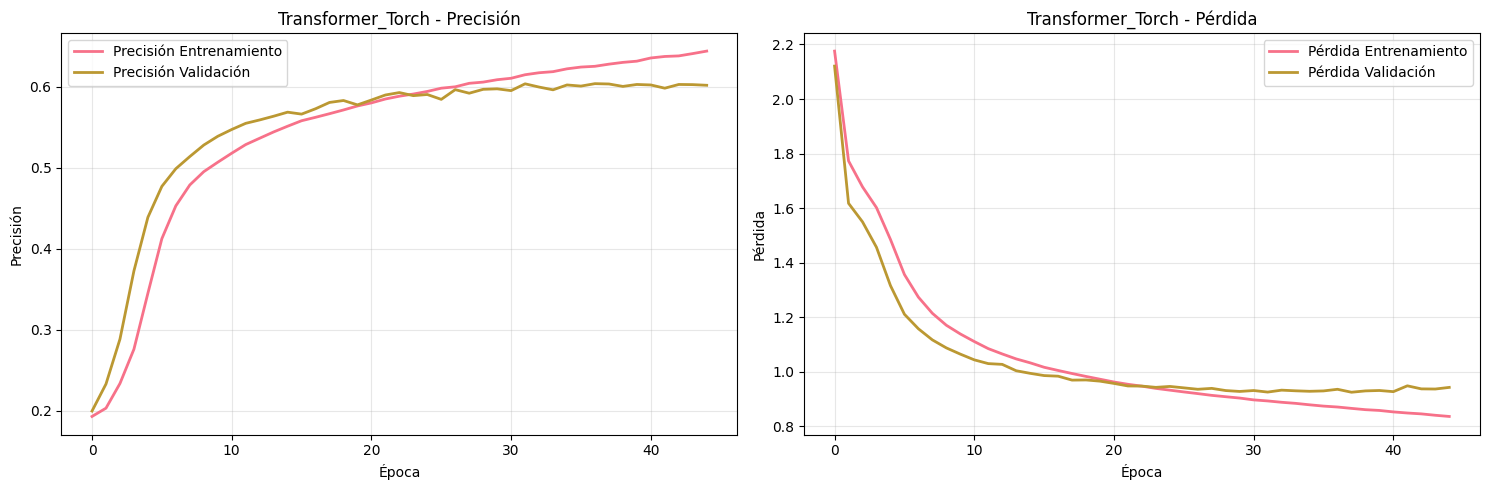

Matriz de confusión guardada en: output/project_part_4/Transformer_Torch_confusion_matrix.png


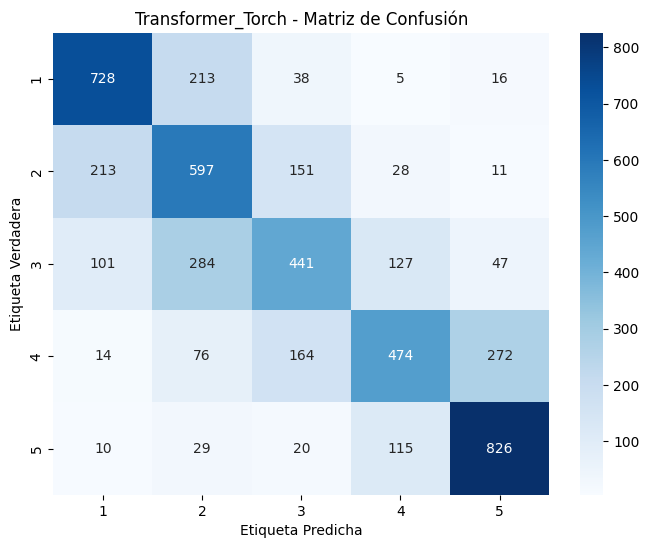

Visualizaciones guardadas en: output/project_part_4


In [9]:
print("=== Generando visualizaciones ===")

# Historia de entrenamiento
history = training_results['history']

# Graficar historia de entrenamiento (perdida y accuracy)
Visualizer.plot_training_history(
    history=history,
    model_name=MODEL_TYPE,
    save_path=os.path.join(OUTPUT_DIR, f'{MODEL_TYPE}_history.png'),
    framework='pytorch'
)

# Matriz de confusion
Visualizer.plot_confusion_matrix(
    y_true=test_results['labels'],
    y_pred=test_results['predictions'],
    class_names=[f"{i+1}" for i in range(num_classes)],
    model_name=MODEL_TYPE,
    save_path=os.path.join(OUTPUT_DIR, f'{MODEL_TYPE}_confusion_matrix.png')
)

print("Visualizaciones guardadas en:", OUTPUT_DIR)

## 9. Guardado de Resultados del Experimento

In [10]:
print("=== Guardando resultados del experimento ===")

# Reporte de clasificacion
from sklearn.metrics import classification_report as sklearn_classification_report
classification_rep = sklearn_classification_report(
    test_results['labels'],
    test_results['predictions'],
    target_names=[f"{i+1}" for i in range(num_classes)],
    output_dict=True
)

# Guardar componentes con nombre unico (tokenizer, label_encoder, etc)
save_model_components_torch(
    model_name=MODEL_SAVE_NAME,
    model=model,
    tokenizer=data_loader.tokenizer,
    label_encoder=data_loader.label_encoder,
    max_length=MAX_LENGTH,
    model_dir=MODEL_DIR
)

# Corregir model_path en training_results para que coincida con el nombre guardado
training_results['model_path'] = f"{MODEL_DIR}/{MODEL_SAVE_NAME}.pth"

# Preparar datos del experimento
experiment_data = {
    'experiment_name': f"{EXPERIMENT_NAME}_{EXPERIMENT_TIMESTAMP}",
    'configuration': {
        'model_type': MODEL_TYPE,
        'model_save_name': MODEL_SAVE_NAME,
        'framework': 'pytorch',
        'language_filter': FILTER_LANGUAGE,
        'max_vocab_size': MAX_VOCAB_SIZE,
        'max_length': MAX_LENGTH,
        'embedding_dim': EMBEDDING_DIM,
        'num_heads': NUM_HEADS,
        'num_layers': NUM_LAYERS,
        'dim_feedforward': DIM_FEEDFORWARD,
        'dropout_rate': DROPOUT_RATE,
        'pooling': POOLING,
        'epochs': EPOCHS,
        'batch_size': BATCH_SIZE,
        'learning_rate': LEARNING_RATE,
        'weight_decay': WEIGHT_DECAY,
        'clip_grad_norm': CLIP_GRAD_NORM,
        'warmup_steps': WARMUP_STEPS,
        'patience': PATIENCE,
        'total_parameters': total_params,
        'gpu_used': gpu_info['gpu_available']
    },
    'dataset_info': {
        'train_samples': len(train_loader.dataset),
        'val_samples': len(val_loader.dataset),
        'test_samples': len(test_loader.dataset),
        'num_classes': num_classes,
        'vocab_size': vocab_size,
        'use_title_and_body': USE_TITLE_AND_BODY
    },
    'training_results': training_results,
    'evaluation_metrics': {
        'test_accuracy': test_results['test_accuracy'],
        'test_loss': test_results['test_loss'],
        'f1_macro': classification_rep['macro avg']['f1-score'],
        'f1_weighted': classification_rep['weighted avg']['f1-score'],
        'classification_report': classification_rep
    },
    'gpu_info': gpu_info
}

# Guardar experimento
results_mgr = ResultsManager(output_dir="output", project_part=PROJECT_PART)
experiment_id = results_mgr.save_experiment_results(experiment_data)

print(f"\nExperimento #{experiment_id} guardado")
print(f"Modelo guardado en: {MODEL_DIR}/{MODEL_SAVE_NAME}.pth")

=== Guardando resultados del experimento ===
Modelo guardado: models/project_part_4/Transformer_Torch_20251130_010009.pth
  - Configuración guardada: {'vocab_size': 48283, 'embedding_dim': 512, 'num_classes': 5, 'num_heads': 8, 'num_layers': 6, 'dim_feedforward': 2048, 'dropout_rate': 0.1, 'max_length': 200, 'pooling': 'mean'}
Tokenizer guardado: models/project_part_4/Transformer_Torch_20251130_010009_tokenizer.pkl
Label encoder guardado: models/project_part_4/Transformer_Torch_20251130_010009_label_encoder.pkl
Componentes guardados en models/project_part_4/
Experiment 3 (Transformer_PyTorch_20251130_010009) saved to output/project_part_4/experiment_history.json

Experimento #3 guardado
Modelo guardado en: models/project_part_4/Transformer_Torch_20251130_010009.pth
